In [1]:
from arhmm import ARHMM, find_permutation, lse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set(palette="colorblind")

In [2]:
obs_dim = 20
rr_dim = 15
state_num = 3
time_bin = 1000

In [3]:
true_arhmm = ARHMM(D=obs_dim, Q=rr_dim, K=state_num, sigma2_y0=1e-4, pi_0 = None, alpha=5e0, P_diag=4e1,
                 a1=5e1, sigma2_b=1e0, sigma2_A=1e-4,
                 sigma2_y=1e0, a=1, c=1, RHO = -1)

In [4]:
true_states, obs, deviance = true_arhmm.sample(T=time_bin)

In [5]:
deviance

-24036.70351297938

In [6]:
# mean0 = []
# phi_mean = []
# y_mean = []
# noise_mean = []
# for i in range(len(noise)):
#     #mean0.append(means[i][4])
#     mean0.append(np.sum(abs(means[i])))
#     #phi_mean.append(phis[i][4])
#     y_mean.append(np.sum(abs(obs_denoised[:,i])))
#     #y_mean.append(obs_denoised[4,i])
#     noise_mean.append(np.sum(abs(noise[i])))
#     #noise_mean.append(noise[i][4])

In [7]:
# fig, ax = plt.subplots(figsize=(16, 10))
# ax.plot(phi_mean)
# ax.ticklabel_format(useOffset=False, style='plain')
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)
# plt.ylabel("phi", fontsize=34)
# plt.xlabel("Time bins", fontsize=34)
# plt.show()

# fig, ax = plt.subplots(figsize=(16, 10))
# ax.plot(mean0)
# ax.ticklabel_format(useOffset=False, style='plain')
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)
# plt.ylabel("b + A phi", fontsize=34)
# plt.xlabel("Time bins", fontsize=34)
# plt.show()

# fig, ax = plt.subplots(figsize=(16, 10))
# ax.plot(y_mean)
# ax.ticklabel_format(useOffset=False, style='plain')
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)
# plt.ylabel("y", fontsize=34)
# plt.xlabel("Time bins", fontsize=34)
# plt.show()

# fig, ax = plt.subplots(figsize=(16, 10))
# ax.plot(noise_mean)
# ax.ticklabel_format(useOffset=False, style='plain')
# plt.xticks(fontsize=26)
# plt.yticks(fontsize=26)
# plt.ylabel("noise_mean", fontsize=34)
# plt.xlabel("Time bins", fontsize=34)
# plt.show()

0.002263633582503882
0.002478433183070074


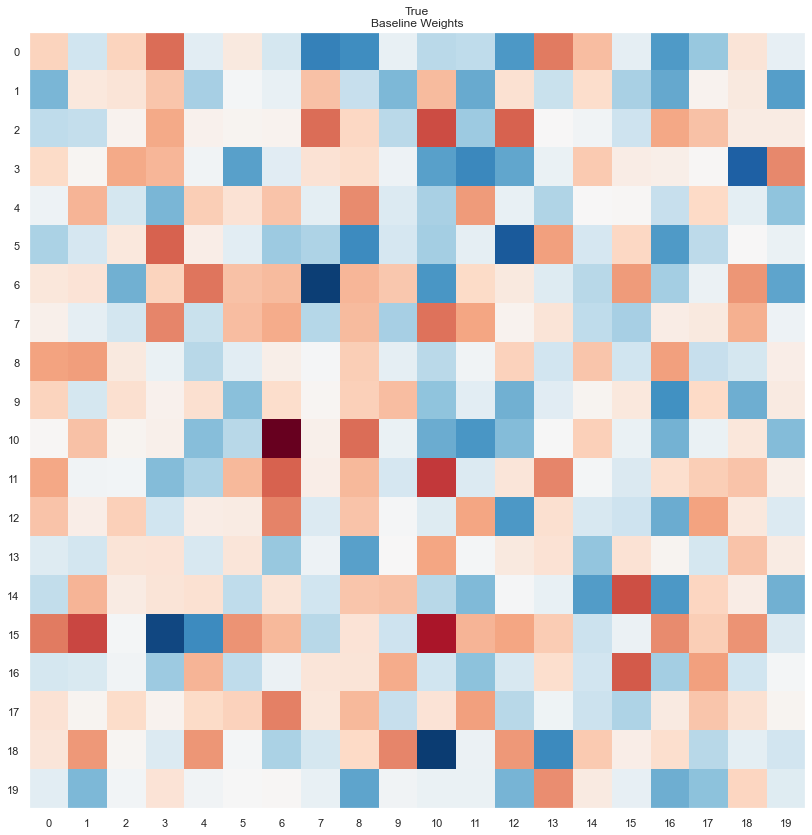

In [8]:
# Plot a dynamics matrix
plt.figure(figsize=(64, 32))

vlim = abs(true_arhmm.A[0]).max()

plt.subplot(141)
plt.grid(b=None)
plt.imshow(true_arhmm.A[0], vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(obs_dim))
plt.yticks(np.arange(obs_dim))
plt.title("True\nBaseline Weights")
print(np.mean(true_arhmm.A[0]))
print(np.mean(true_arhmm.A[1]))

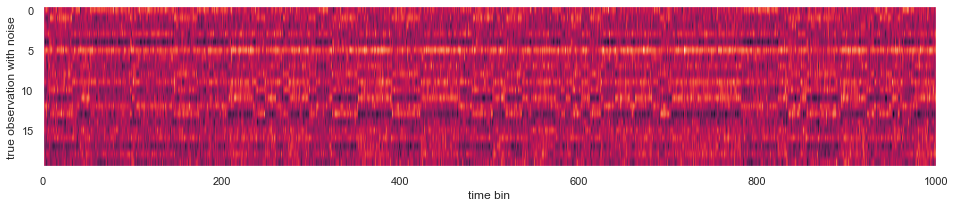

In [9]:
#Plot the observation
plt.figure(figsize=(16, 10))
# Create Cmap for visualizing categorical observations
plt.subplot(312)
plt.grid(b=None)
plt.imshow(obs, aspect="auto")
plt.xlim(0, time_bin)
plt.ylabel("true observation with noise")
plt.xlabel("time bin")
plt.show()

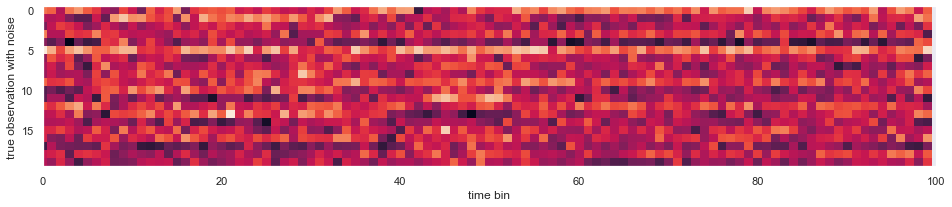

In [10]:
window = 100
#Plot the observation
plt.figure(figsize=(16, 10))
# Create Cmap for visualizing categorical observations
plt.subplot(312)
plt.grid(b=None)
plt.imshow(obs[:,:window], aspect="auto")
plt.xlim(0, window)
plt.ylabel("true observation with noise")
plt.xlabel("time bin")
plt.show()

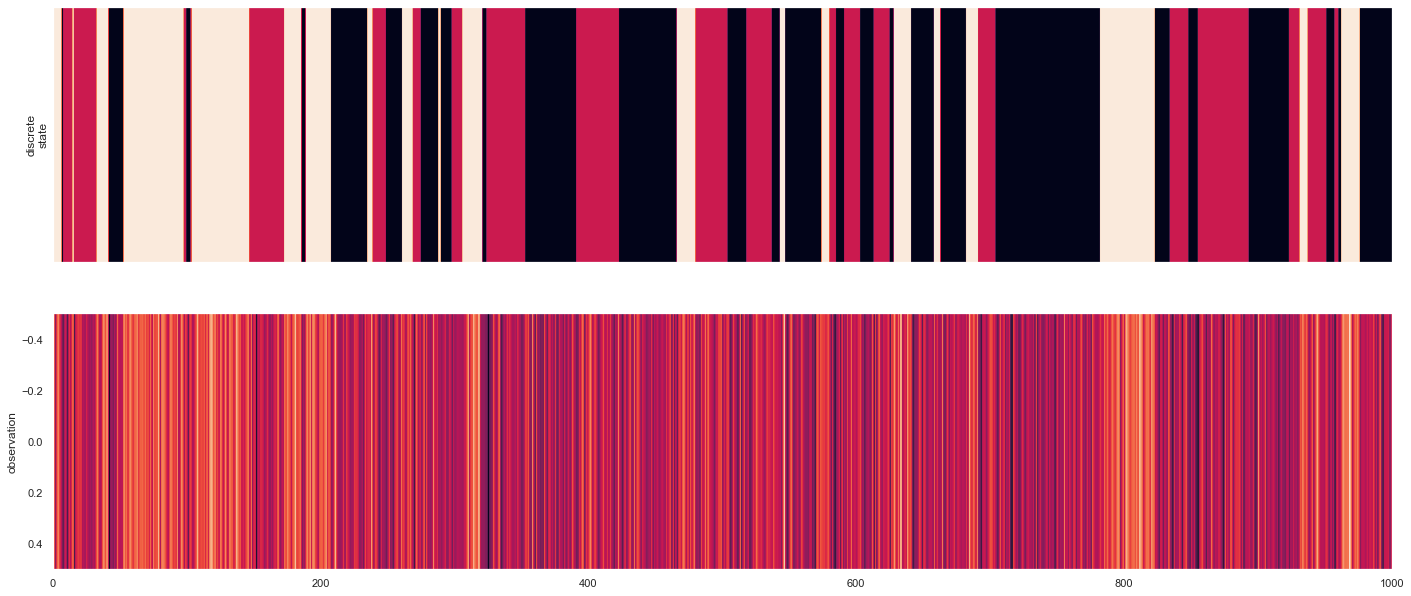

In [11]:
# Plot the data
plt.figure(figsize=(24, 16))

plt.subplot(312)
plt.imshow(true_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bin)
plt.ylabel("discrete\nstate")
plt.yticks([])

obs_flat = np.array([x[0] for x in obs.T])
# Create Cmap for visualizing categorical observations
plt.subplot(313)
plt.imshow(obs_flat[None,:], aspect="auto", )
plt.xlim(0, time_bin)
plt.ylabel("observation")
plt.grid(b=None)
plt.show()

[[0.9376358  0.03033585 0.03202836]
 [0.04907255 0.92729628 0.02363117]
 [0.02866722 0.02077369 0.95055909]]


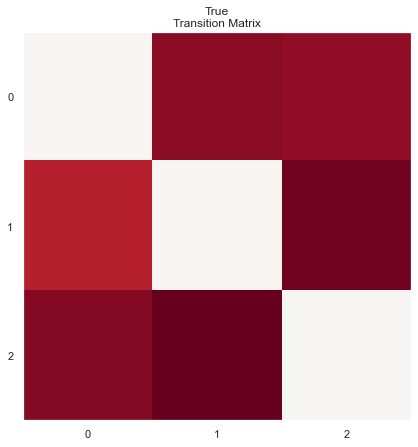

In [12]:
# Plot the true and inferred input effects
plt.figure(figsize=(32, 16))

vlim = abs(true_arhmm.log_P).max()

plt.subplot(141)
plt.grid(b=None)
plt.imshow(true_arhmm.log_P, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(state_num))
plt.yticks(np.arange(state_num))
plt.title("True\nTransition Matrix")
print(true_arhmm.P)

In [13]:
abs(obs).mean()

1.2081006102894962

In [14]:
abs(true_arhmm.A[0]).mean()

0.07639282562415549

In [15]:
abs(true_arhmm.A[0]).var()

0.003346892047008366

In [16]:
len(np.where(abs(true_arhmm.A) < abs(true_arhmm.A).mean())[0])

700

In [17]:
# Q = dict()
# for q in range(1, obs_dim):
#     print("reduced rank Q={}".format(q))
#     arhmm = ARHMM(D=obs_dim, Q=q, K=state_num)
#     samples, log_joints = arhmm.run_gibbs_sampler(obs, iterations=30)
#     Q[q] = (deepcopy(samples), deepcopy(log_joints))

In [18]:
chains = []
chain_n = 2
for i in range(chain_n):
    print("Chain #{}".format(i))
    arhmm = ARHMM(D=obs_dim, Q=rr_dim, K=state_num, sigma2_y0=1e0, pi_0 = None, alpha = 1e0, P_diag = 1e1,
                 a1=2e1, sigma2_b=1e0, sigma2_A=1e-2,
                 sigma2_y=1e0, a=1, c=1, RHO = -1)
    samples, log_joints = arhmm.run_gibbs_sampler(obs, iterations=70)
    chains.append((deepcopy(samples),deepcopy(log_joints)))

Chain #0
Initial log joint: -63156.70528314739
------------------------------------------------
Iteration 0
Log joint: -27620.354269961128
------------------------------------------------
Iteration 1
Log joint: -27283.636431441704
------------------------------------------------
Iteration 2
Log joint: -26712.561211221757
------------------------------------------------
Iteration 3
Log joint: -26388.05825458618
------------------------------------------------
Iteration 4
Log joint: -26201.783494055846
------------------------------------------------
Iteration 5
Log joint: -26086.118743300733
------------------------------------------------
Iteration 6
Log joint: -26035.05643392163
------------------------------------------------
Iteration 7
Log joint: -26030.737938613813
------------------------------------------------
Iteration 8
Log joint: -26107.501857958814
------------------------------------------------
Iteration 9
Log joint: -26017.767541973346
-----------------------------------

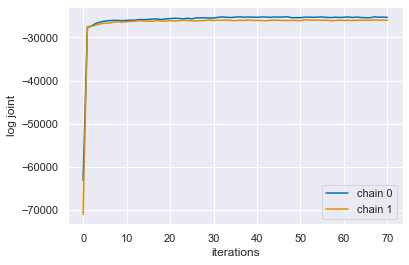

In [19]:
fig = plt.figure()
for i, c in enumerate(chains):
    plt.plot(c[1],label='chain {}'.format(i))
plt.xlabel('iterations', fontsize=12)
plt.ylabel('log joint', fontsize=12)
plt.legend(loc="lower right")
#plt.xlim(xmin=20)
#plt.ylim(ymin=-4956831,ymax=-4556831)
plt.show()

In [20]:
np.where(chains[0][1] == max(chains[0][1]))

(array([47]),)

In [21]:
A_trace = defaultdict(list)
for i, c in enumerate(chains):
    for t in range(len(c[0]['P'])):
        A_trace[i].append(c[0]['P'][t][0,0])

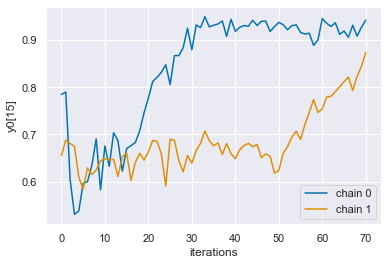

In [22]:
fig = plt.figure()
for i, c in enumerate(chains):
    plt.plot(A_trace[i],label='chain {}'.format(i))
plt.xlabel('iterations', fontsize=12)
plt.ylabel('y0[15]', fontsize=12)
plt.legend(loc="lower right")
plt.show()

In [23]:
z = chains[0][0]['z'][47]
P = chains[0][0]['P'][47]
A_inferred = chains[0][0]['A'][47][2,:,:]
z_transpose = np.transpose(np.where(z == 1))
inferred_states = np.transpose(sorted(z_transpose, key=lambda z_tp: z_tp[1]))[0]

[[0.93991637 0.01388514 0.04619849]
 [0.03294254 0.92640877 0.04064869]
 [0.03284838 0.03878286 0.92836876]]


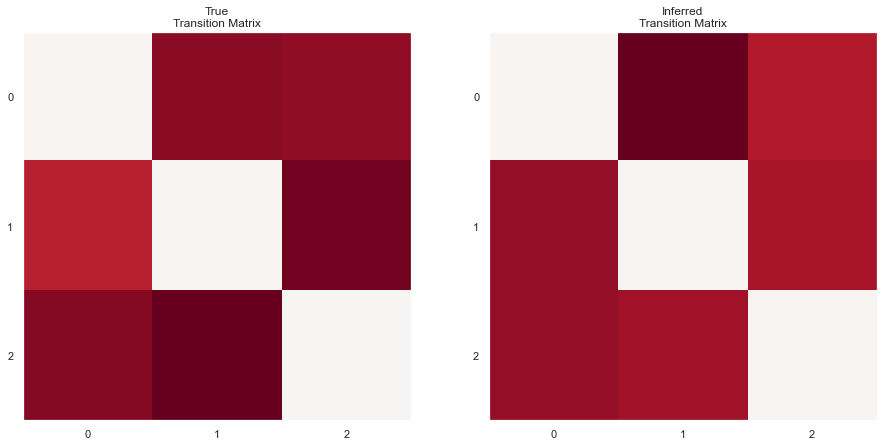

In [24]:
# Plot the true and inferred input effects
plt.figure(figsize=(32, 16))

vlim = abs(true_arhmm.log_P).max()

plt.subplot(141)
plt.grid(b=None)
plt.imshow(true_arhmm.log_P, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(state_num))
plt.yticks(np.arange(state_num))
plt.title("True\nTransition Matrix")

plt.subplot(142)
plt.grid(b=None)
plt.imshow(np.log(P), vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(state_num))
plt.yticks(np.arange(state_num))
plt.title("Inferred\nTransition Matrix")
print(P)

([], [])

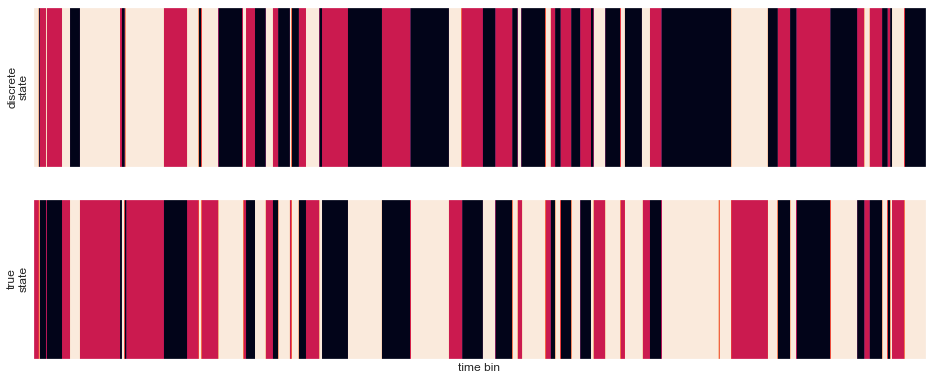

In [25]:
# Plot the data
plt.figure(figsize=(16, 10))

plt.subplot(311)
plt.imshow(true_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bin)
plt.ylabel("discrete\nstate")
plt.yticks([])

plt.subplot(312)
plt.imshow(inferred_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bin)
plt.ylabel("true\nstate")
plt.xlabel("time bin")
plt.yticks([])

In [26]:
perm = list(find_permutation(true_states, inferred_states))
print(perm)

[2, 0, 1]


In [27]:
permuted_states = []
for s in inferred_states:
    permuted_states.append(perm.index(s))
permuted_states = np.asarray(permuted_states)

([], [])

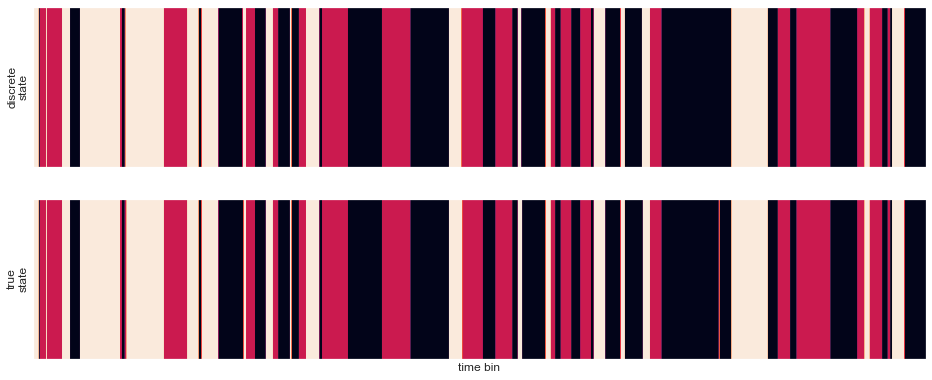

In [28]:
# Plot the data
plt.figure(figsize=(16, 10))

plt.subplot(311)
plt.imshow(true_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bin)
plt.ylabel("discrete\nstate")
plt.yticks([])

plt.subplot(312)
plt.imshow(permuted_states[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, time_bin)
plt.ylabel("true\nstate")
plt.xlabel("time bin")
plt.yticks([])

In [ ]:
# Plot the true and inferred dynamics matrices
plt.figure(figsize=(32, 16))

vlim = abs(true_arhmm.A[1]).max()

plt.subplot(141)
plt.grid(b=None)
plt.imshow(true_arhmm.A[1], vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(obs_dim))
plt.yticks(np.arange(obs_dim))
plt.title("True\nBaseline Weights")

plt.subplot(142)
plt.grid(b=None)
plt.imshow(A_inferred, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(obs_dim))
plt.yticks(np.arange(obs_dim))
plt.title("Inferred Weights")

In [ ]:
one_sample_mses = []
samples = []
for q in range(1, obs_dim):
    idx = np.where(Q[q][1] == max(Q[q][1][20:]))[0][0]
    A_inferred = Q[q][0]['A'][idx]
    b_inferred = Q[q][0]['b'][idx]
    y0_inferred = Q[q][0]['y0'][idx]
    
    samples.append((deepcopy(A_inferred), deepcopy(b_inferred), deepcopy(y0_inferred)))
    
#     plt.figure(figsize=(32, 16))

#     vlim = abs(A_inferred).max()

#     plt.subplot(141)
#     plt.grid(b=None)
#     plt.imshow(A_inferred, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
#     plt.xticks(np.arange(obs_dim))
#     plt.yticks(np.arange(obs_dim))
#     plt.title("Inferred Weights Q={}".format(q))
    
    mse = mean_squared_error(A_inferred.flatten(), true_arhmm.A.flatten())
    one_sample_mses.append(mse)

In [ ]:
one_sample_mses

In [ ]:
print(np.where(one_sample_mses == min(one_sample_mses)))
print(min(one_sample_mses))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot([i for i in range(1,30)],one_sample_mses)
plt.xticks([i for i in range(1,30)])
plt.xlabel("reduced rank Q")
plt.ylabel("mse (1 sample)")
plt.show()

In [ ]:
mses = []
mean_sample = []
for q in range(1, obs_dim):
    A_inferred = np.zeros((len(Q[q][0]['A'][20:]),obs_dim,obs_dim))
    b_inferred = np.zeros((len(Q[q][0]['b'][20:]),obs_dim))
    y0_inferred = np.zeros((len(Q[q][0]['y0'][20:]),obs_dim))
    for i in range(len(Q[q][0]['A'][20:])):
        A_inferred[i] = Q[q][0]['A'][i+20]
        b_inferred[i] = Q[q][0]['b'][i+20]
        y0_inferred[i] = Q[q][0]['y0'][i+20]

    mean = A_inferred.mean(axis=0)
    mean_b = b_inferred.mean(axis=0)
    mean_y0 = y0_inferred.mean(axis=0)
    
    mean_sample.append((deepcopy(mean), deepcopy(mean_b), deepcopy(mean_y0)))
    
#     plt.figure(figsize=(32, 16))

#     vlim = abs(mean).max()

#     plt.subplot(141)
#     plt.grid(b=None)
#     plt.imshow(mean, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
#     plt.xticks(np.arange(obs_dim))
#     plt.yticks(np.arange(obs_dim))
#     plt.title("Inferred Weights Q={}".format(q))
    
    mse = mean_squared_error(mean.flatten(), true_arhmm.A.flatten())
    mses.append(mse)

In [ ]:
mses

In [ ]:
print(np.where(mses == min(mses)))
print(min(mses))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot([i for i in range(1,30)],mses)
plt.xticks([i for i in range(1,30)])
plt.xlabel("reduced rank Q")
plt.ylabel("mse (sample avg)")
plt.show()

In [ ]:
log_pdfs = []
for q in range(1, obs_dim):
    A_inferred = np.zeros((len(Q[q][0]['A'][20:]),obs_dim,obs_dim))
    for i in range(len(Q[q][0]['A'][20:])):
        A_inferred[i] = Q[q][0]['A'][i+20]
        
    var = A_inferred.var(axis=0)
    mean = A_inferred.mean(axis=0)
    
    log_pdf = 0
    
    for d in range(len(true_arhmm.A)):
        log_pdf += multivariate_normal.logpdf(true_arhmm.A[d], mean=mean[d], cov=np.diag(var[d]))
        
    log_pdfs.append(log_pdf)

In [ ]:
log_pdfs

In [ ]:
print(np.where(log_pdfs == max(log_pdfs)))
print(max(mses))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot([i for i in range(1,30)],log_pdfs)
plt.xticks([i for i in range(1,30)])
plt.xlabel("reduced rank Q")
plt.ylabel("log_prob")
plt.show()

In [ ]:
def reconstruct_observation(y, sample):
    D = y.shape[0]
    T = y.shape[1]
    
    A = sample[0]
    b = sample[1]
    y0 = sample[2]
    
    bA = np.concatenate((b[:, np.newaxis], A), axis=1)
    
    RHO = -1
    
    y_reconstruct= np.zeros((D,T))
    
    for t in range(T):
        if t == 0:
            # reconstruct y1
            C = (np.cos(np.log(1 + 1))+1) / 2
            y_pred = multivariate_normal.rvs(mean=b + np.dot(A, C*y0), cov=1e1 * np.eye(D))
            y_reconstruct[:,0] = deepcopy(y_pred)
            continue
        
        phi = np.ones(D+1)
        # reconstruct
        for tau in range(1, t+1):
            C_tau = np.log(tau + 1)
            if C_tau >= RHO-np.pi and C_tau <= RHO+np.pi:
                C_tau_cos = (np.cos(C_tau - RHO)+1) / 2
            else:
                C_tau_cos = 0
            phi[1:] += C_tau_cos*y[:,t-tau]

        y_pred = multivariate_normal.rvs(mean=np.dot(bA, phi), cov=1e1 * np.eye(D))
        y_reconstruct[:,t] = deepcopy(y_pred)
    
    return y_reconstruct

In [ ]:
selected_samples = [(0, samples[0]), (23, samples[23]), (27, samples[27])]

In [ ]:
vlim = abs(obs).max()
for q, sample in selected_samples:
    y_reconstruct = reconstruct_observation(obs, sample)
    
    # Plot the data
    plt.figure(figsize=(16, 10))
    # Create Cmap for visualizing categorical observations
    plt.subplot(313)
    plt.grid(b=None)
    plt.imshow(y_reconstruct, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect="auto")
    plt.xlim(0, time_bin)
    plt.ylabel("q={} observation".format(q+1))
    plt.xlabel("time bin")
    plt.show()
    

# Plot the data
plt.figure(figsize=(16, 10))
# Create Cmap for visualizing categorical observations
plt.subplot(313)
plt.grid(b=None)
plt.imshow(obs, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect="auto")
plt.xlim(0, time_bin)
plt.ylabel("true observation")
plt.xlabel("time bin")
plt.show()

In [ ]:
vlim = abs(obs).max()
for q, sample in selected_samples:
    y_reconstruct = reconstruct_observation(obs, sample)
    
    # Plot the data
    plt.figure(figsize=(16, 10))
    # Create Cmap for visualizing categorical observations
    plt.subplot(313)
    plt.grid(b=None)
    plt.imshow(obs-y_reconstruct, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect="auto")
    plt.xlim(0, time_bin)
    plt.ylabel("q={} observation residual".format(q+1))
    plt.xlabel("time bin")
    plt.show()
    
#Plot the data
plt.figure(figsize=(16, 10))
# Create Cmap for visualizing categorical observations
plt.subplot(313)
plt.grid(b=None)
plt.imshow(obs, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect="auto")
plt.xlim(0, time_bin)
plt.ylabel("true observation")
plt.xlabel("time bin")
plt.show()

In [ ]:
vlim = abs(true_arhmm.A).max()
for q, sample in selected_samples:
    # Plot the inferred A
    plt.figure(figsize=(32, 16))

    plt.subplot(141)
    plt.grid(b=None)
    plt.imshow(sample[0], vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
    plt.xticks(np.arange(obs_dim))
    plt.yticks(np.arange(obs_dim))
    plt.title("Inferred Weights q={}".format(q+1))
    
# Plot the true A
plt.figure(figsize=(32, 16))
plt.subplot(141)
plt.grid(b=None)
plt.imshow(true_arhmm.A, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(obs_dim))
plt.yticks(np.arange(obs_dim))
plt.title("True\nBaseline Weights")

In [ ]:
vlim = abs(true_arhmm.A).max()
for q, sample in selected_samples:
    # Plot the inferred A
    plt.figure(figsize=(32, 16))

    plt.subplot(141)
    plt.grid(b=None)
    plt.imshow(true_arhmm.A-sample[0], vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
    plt.xticks(np.arange(obs_dim))
    plt.yticks(np.arange(obs_dim))
    plt.title("Inferred Weights q={} residual".format(q+1))
# Plot the true A
plt.figure(figsize=(32, 16))
plt.subplot(141)
plt.grid(b=None)
plt.imshow(true_arhmm.A, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(obs_dim))
plt.yticks(np.arange(obs_dim))
plt.title("True\nBaseline Weights")

In [ ]:
for q, sample in enumerate(mean_sample):
    y_reconstruct = reconstruct_observation(obs, sample)
    # Plot the data
    plt.figure(figsize=(16, 10))
    # Create Cmap for visualizing categorical observations
    plt.subplot(313)
    plt.grid(b=None)
    plt.imshow(y_reconstruct, aspect="auto")
    plt.xlim(0, time_bin)
    plt.ylabel("q={} observation".format(q+1))
    plt.xlabel("time bin")
    plt.show()

In [ ]:
#Set average values of off-diagonal entries for each discrete state
alphas=[.06,.15]
for k in range(K):
    alpha=alphas[k]
    #Create skew symmetric dynamics matrices
    A0=np.zeros([D,D])
    for i in range(D-1):
        A0[i,i+1:]=alpha*np.random.randn(D-1-i)
    A0=(A0-A0.T)
    A=A0+np.identity(D)
    #Normalize so that the largest eigenvalue becomes less than 1
    A=A/(np.max(np.abs(np.linalg.eigvals(A)))+.01)